# Importando as Bibliotecas

In [132]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import math
import datetime as dt
import lightgbm as lgb
import optuna
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn import metrics
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve


# Importando a Base de Dados

In [106]:
caminho = r"/content/drive/MyDrive/8ºSEMESTRE/TG/base_final.parquet"
base = pd.read_parquet(caminho)
base = base[base['var_2'] > 15]

In [107]:
base['var_325'] = base['var_325'].astype('category')
base['var_1'] = base['var_1'].astype('category')
base['var_339'] = base['var_339'].astype('category')
base['CAT_var_275'] = base['CAT_var_275'].astype('category')
base['var_365'] = base['var_365'].astype('category')
base['var_resposta'] = base['var_resposta'].astype('category')

# Amostragem

In [108]:
treino = base[base['split'] == "Treinamento"]
import random
np.random.seed(290)
split = np.random.choice(['Treinamento', 'Validacao'], size = len(treino), p = [0.8, 0.2])


treino['split'] = split
print(treino['split'].value_counts())

split
Treinamento    263226
Validacao       65773
Name: count, dtype: int64


<ipython-input-108-d98145f76aa2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treino['split'] = split


In [109]:
treinof = treino[treino['split'] == "Treinamento"]
treinof = treinof.drop(columns = ["split"])

X_treino = treinof.drop(["var_resposta"],axis=1)
Y_treino = treinof["var_resposta"]
print(X_treino.shape)

(263226, 213)


In [110]:
valid = treino[treino['split'] == "Validacao"]
valid = valid.drop(columns = ["split"])


X_valid = valid.drop(["var_resposta"],axis=1)
Y_valid = valid["var_resposta"]
print(X_valid.shape)

(65773, 213)


In [134]:
teste = base[base['split'] == "Teste"]
teste = teste.drop(columns = ["split"])
X_teste = teste.drop(["var_resposta"],axis=1)
Y_teste = teste["var_resposta"]
print(X_teste.shape)

(82470, 213)


# Otimização Baeysiana

In [ ]:
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.4),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.2, 1), # Ajustado para datasets grandes
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 30),
        'max_delta_step': trial.suggest_int('max_delta_step', 1, 10),
        #'lambda': trial.suggest_float('lambda', 0, 1),
        'alpha': trial.suggest_float('alpha', 0, 1),
    }
    class_xgb = XGBClassifier(**params,enable_categorical=True)
    class_xgb.fit(X_treino, Y_treino)
    predicoes = class_xgb.predict_proba(X_valid)[:, 1]
    auc = metrics.roc_auc_score(Y_valid, predicoes)
    return auc

In [ ]:
# Criando o estudo e otimizando
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2024-11-10 15:36:40,771] A new study created in memory with name: no-name-afe8482e-bdd7-434e-9bab-f03b6ca713e0
[I 2024-11-10 15:38:35,313] Trial 0 finished with value: 0.8047319575053999 and parameters: {'learning_rate': 0.007992005511627853, 'n_estimators': 311, 'max_depth': 6, 'subsample': 0.7633860033273705, 'colsample_bytree': 0.5515095030889949, 'gamma': 1.8122774219263482, 'min_child_weight': 1, 'max_delta_step': 3, 'alpha': 0.5805366515058283}. Best is trial 0 with value: 0.8047319575053999.
[I 2024-11-10 15:39:20,937] Trial 1 finished with value: 0.808727850092811 and parameters: {'learning_rate': 0.16419753616624874, 'n_estimators': 141, 'max_depth': 6, 'subsample': 0.6770811268270118, 'colsample_bytree': 0.514729789952534, 'gamma': 2.318894508548281, 'min_child_weight': 13, 'max_delta_step': 9, 'alpha': 0.8799981652059594}. Best is trial 1 with value: 0.808727850092811.
[I 2024-11-10 15:40:47,516] Trial 2 finished with value: 0.775526778905747 and parameters: {'learning_ra

In [10]:
print('Melhores hiperparâmetros:', study.best_params)
print('Melhor AUC:', study.best_value)
# Melhores hiperparâmetros: {learning_rate= 0.03332747285295623, n_estimators= 244,max_depth= 9,subsample= 0.8675817069630809,colsample_bytree= 0.8,gamma= 1.7240110839139073,min_child_weight= 17}
# Melhor AUC: 0.814114455274121

In [11]:
# !pip install bayesian-optimization
# !pip install scikit-optimize

In [ ]:
from bayes_opt import BayesianOptimization

# Função para ajuste do modelo com parâmetros específicos
def modelFitter(learning_rate, n_estimators, max_depth, colsample_bytree, min_child_weight, gamma,subsample):
    # Defina os parâmetros do modelo XGBoost com os valores fornecidos pelo otimizador
    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "learning_rate": learning_rate,
        "n_estimators": int(n_estimators),
        "max_depth": int(max_depth),
        "colsample_bytree": colsample_bytree,
        "min_child_weight": int(min_child_weight),
        "subsample":float(subsample),
        "gamma": gamma
    }

    # Inicializa o classificador XGBoost com os parâmetros
    class_xgb = xgb.XGBClassifier(**params,enable_categorical=True)
    class_xgb.fit(X_treino, Y_treino)

    # Faz previsões no conjunto de validação
    predicoes = class_xgb.predict_proba(X_valid)[:, 1]

    # Calcula o AUC
    auc = metrics.roc_auc_score(Y_valid, predicoes)
    return auc

# Define os limites dos hiperparâmetros para a otimização bayesiana
params = {
    "learning_rate": (0.0001, 0.4),
    "n_estimators": (100, 500),
    "max_depth": (3, 10),
    "colsample_bytree": (0.5, 1),
    "subsample": (0.5, 1),
    "min_child_weight": (1, 30),
    "gamma": (0, 5)
}

# Inicializa a otimização bayesiana
optimizer = BayesianOptimization(
    f=modelFitter,
    pbounds=params,
    random_state=1
)

# Executa a otimização
optimizer.maximize(init_points=15, n_iter=15)


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.7845    | 0.7085    | 3.602     | 0.0001457 | 5.116     | 5.256     | 136.9     | 0.5931    |
| 2         | 0.8062    | 0.6728    | 1.984     | 0.2156    | 5.934     | 20.87     | 181.8     | 0.9391    |
| 3         | 0.8062    | 0.5137    | 3.352     | 0.167     | 6.911     | 5.071     | 179.2     | 0.9004    |
| 4         | 0.7722    | 0.9841    | 1.567     | 0.277     | 9.135     | 26.94     | 134.0     | 0.5195    |
| 5         | 0.8126    | 0.5849    | 4.391     | 0.03943   | 5.948     | 28.78     | 313.3     | 0.8459    |
| 6         | 0.8038    | 0.6578    | 3.433     | 0.3339    | 3.128     | 22.75     | 495.5     | 0.8741    |
| 7         | 0.8134    | 0.6402    | 3.946     | 0.04138   | 6.135     | 27.35     | 217.4     | 0.6439    |
| 8       

In [12]:
# Best parameters and AUC score
# print(optimizer.max)

In [13]:
# optimizer.max['params']

# Modelagem

In [112]:
from xgboost import XGBClassifier
class_xgb = XGBClassifier(learning_rate= 0.03332747285295623,
                          tree_method = 'hist',
                          importance_type = 'gain',
                          n_estimators= 244,
                          max_depth= 9,
                          subsample= 0.8675817069630809,
                          colsample_bytree= 0.8,
                          gamma= 1.7240110839139073,
                          min_child_weight= 17,
                          alpha = 0,
                          reg_lambda = 1,
                          random_state=29,
                          enable_categorical=True)

inicio = time.time()
class_xgb.fit(X_treino,Y_treino)
fim = time.time()

tempo_execucao = fim - inicio
print(f"Tempo de execução: {tempo_execucao} segundos")



Tempo de execução: 123.63349103927612 segundos


# Previsões

In [113]:
inicio = time.time()
predicoes = class_xgb.predict_proba(X_teste)
fim = time.time()

tempo_execucao = fim - inicio
print(f"Tempo de fazer as previsões: {tempo_execucao} segundos")


Tempo de fazer as previsões: 1.216834306716919 segundos


# Descritiva

In [114]:
pred_Y = pd.Series(predicoes[:,0])
pred_Y.describe()

,0
count,82470.000000
mean,0.946809
std,0.077742
min,0.125503
25%,0.940718
50%,0.973272
75%,0.987778
max,0.998760


In [115]:
np.savetxt(r'/content/drive/MyDrive/8ºSEMESTRE/TG/predicoes_xgb.txt', predicoes, delimiter=';')

# Curva ROC

In [116]:
auc = metrics.roc_auc_score(Y_teste, predicoes[:, 1])
auc #0.8200765433598387

0.8203444670684071

In [117]:
Gini = 2*auc-1 #0.6401530867196774
Gini

0.6406889341368143

In [118]:
base['var_resposta'].value_counts(normalize=True)

,proportion
var_resposta,
0,0.946241
1,0.053759


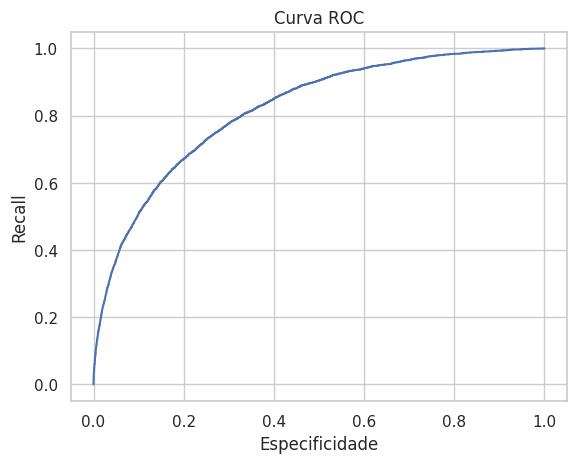

In [119]:
fpr, tpr, corte = metrics.roc_curve(Y_teste, 1-pred_Y)

plt.plot(fpr, tpr)
plt.xlabel('Especificidade')
plt.ylabel('Recall')
plt.title('Curva ROC')
plt.show()

# Análise do Ponto de Corte

In [ ]:
Y_teste_p_maus = 1 - Y_teste.astype('int')

In [127]:
# Definindo os thresholds
threshold1 = 0.855
threshold2 = 0.946
threshold3 = 0.947

previsoes_threshold1 = (pred_Y < threshold3).astype(int)

sum(previsoes_threshold1)

23176

# Matriz de Confusão e medidas de desempenho

In [128]:
matriz_confusao = confusion_matrix(previsoes_threshold1,Y_teste)
matriz_confusao_df = pd.DataFrame(
    matriz_confusao,
    index=['Classe 0 (Previsto)', 'Classe 1 (Previsto)'],
    columns=['Classe 0 (Real)', 'Classe 1 (Real)']
)

print(matriz_confusao_df)

                     Classe 0 (Real)  Classe 1 (Real)
Classe 0 (Previsto)            58128             1166
Classe 1 (Previsto)            19948             3228


In [135]:
VN,FN,FP,VP = matriz_confusao.ravel()

# Calculando as métricas
sensibilidade = recall_score(Y_teste, previsoes_threshold1)
especificidade = VN/(VN+FP)
precisao = precision_score(Y_teste, previsoes_threshold1)
vpn = VN/(VN+FN)
f1 = f1_score(Y_teste, previsoes_threshold1)
acuracia = accuracy_score(Y_teste, previsoes_threshold1)

# Exibindo as métricas
print("Sensibilidade:", sensibilidade)
print("Especificidade:", especificidade)
print("Precisão:", precisao)
print("VPN:", vpn)
print("F1:", f1)
print("Acurácia:", acuracia)


Sensibilidade: 0.7346381429221666
Especificidade: 0.744505353757877
Precisão: 0.139282015878495
VPN: 0.9803352784430128
F1: 0.23416757344940153
Acurácia: 0.743979628955984


In [136]:
teste = base[base['split'] == "Teste"]
teste = teste.drop(columns = ["split"])
X_teste = teste.drop(["var_resposta"],axis=1)
Y_teste = teste["var_resposta"]
print(X_teste.shape)

(82470, 213)


# KS

In [137]:
from scipy.stats import ks_2samp
predicoes_df = pd.DataFrame(predicoes, columns=["Prob_Classe_0", "Prob_Classe_1"], index=X_teste.index)
predicoes_df = predicoes_df.reset_index(drop=True)

cal_KS = Y_teste.reset_index(drop=True)
teste_com_predicoes = pd.concat([cal_KS, predicoes_df], axis=1)

ks_2samp(teste_com_predicoes[teste_com_predicoes["var_resposta"] == 1 ]['Prob_Classe_0'],  teste_com_predicoes[teste_com_predicoes["var_resposta"] == 0 ]['Prob_Classe_0']) #0.4750229302853798


KstestResult(statistic=0.4797365896511139, pvalue=0.0, statistic_location=0.94701546, statistic_sign=1)

# SHAP

In [ ]:
import shap

explainer = shap.Explainer(class_xgb)
shap_values = explainer(X_treino)
shap.summary_plot(shap_values, X_treino, plot_type="violin", feature_names=X_treino.columns)
plt.title("SHAP values (impact on model output)")
plt.show()

In [ ]:
# pip install shap

In [ ]:
import shap
explainer = shap.KernelExplainer(class_xgb.predict_proba(X_treino)[:, 1],X_treino)
shap_values = explainer.shap_values(X_treino,nsamples=100)

In [ ]:
shap.summary_plot(shap_values,X_treino,feature_names=X_treino.colunmns)

In [ ]:
df = pd.DataFrame(predicoes, columns=['Y=1', 'Y=0'])

,Y=1,Y=0
0,0.006346,0.993654
1,0.019541,0.980459
2,0.115941,0.884059
3,0.006594,0.993406
4,0.005338,0.994662
...,...,...
82465,0.004276,0.995724
82466,0.012115,0.987885
82467,0.007891,0.992109
82468,0.001711,0.998289


In [ ]:
Y_teste['var_resposta'].value_counts()

,count
var_resposta,
1,77984
0,4486


In [129]:
from scipy.stats import ks_2samp
Y_teste = Y_teste.reset_index()
Y_teste.columns = ['Index', 'var_resposta']
Y_teste["score"] = predicoes[:, 1]*1000
ks_2samp(Y_teste[Y_teste["var_resposta"]== 1 ]['score'],  Y_teste[Y_teste["var_resposta"]== 0 ]['score']) #0.47129707185497177

KstestResult(statistic=0.4797365896511138, pvalue=0.0, statistic_location=52.984, statistic_sign=-1)

SHAP


In [ ]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(class_xgb)

In [ ]:
shap_values = explainer(X_treino)

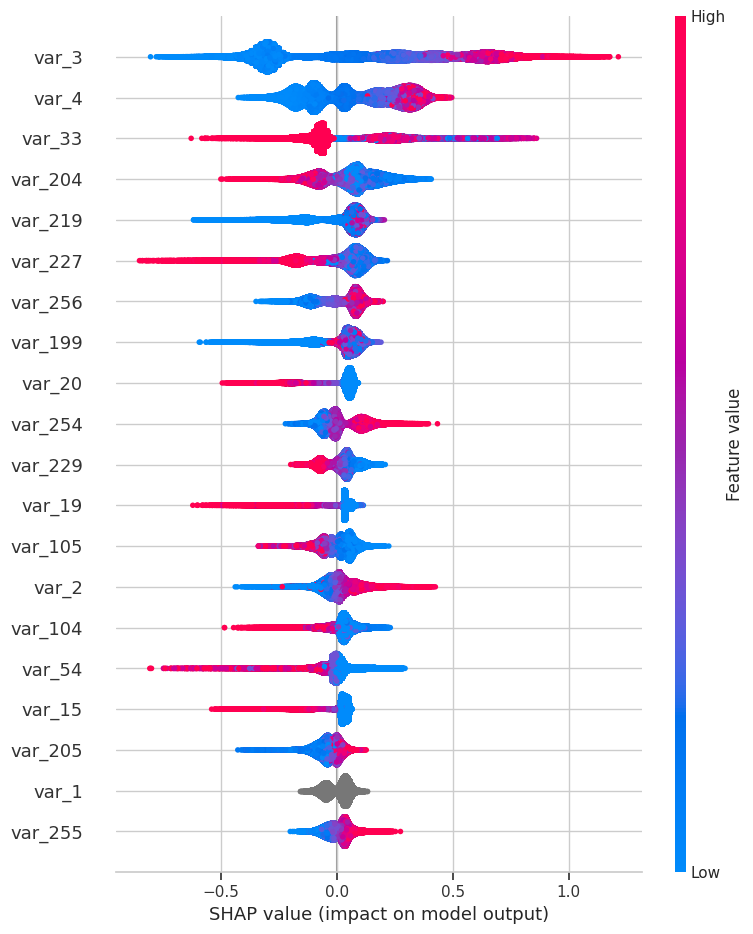

In [ ]:
shap.summary_plot(shap_values, X_treino)

# Features more importantes


<Figure size 3600x2200 with 0 Axes>

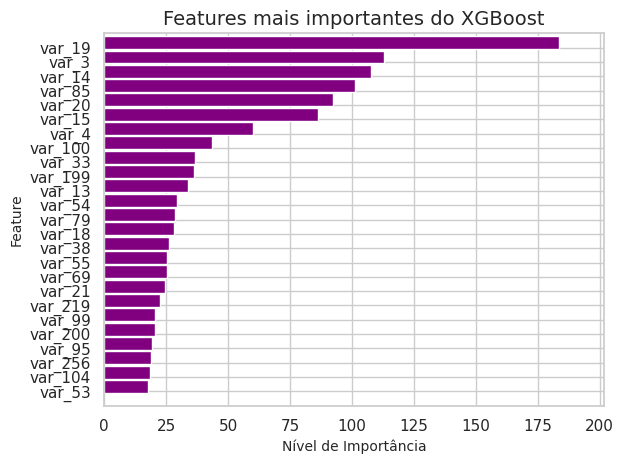

In [121]:
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(36, 22))
sns.set(style="whitegrid")

ax = xgb.plot_importance(class_xgb, importance_type='gain', max_num_features=25, color='purple')

for t in ax.texts:
    t.set_text('')

for patch in ax.patches:
    patch.set_height(0.9)


plt.title('Features mais importantes do XGBoost', fontsize=14)
plt.xlabel('Nível de Importância', fontsize=10)
plt.ylabel('Feature', fontsize=10)
plt.tight_layout()
plt.show()


# Descritiva

## Boxplot

<ipython-input-138-6b95ed851ee2>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=teste_com_predicoes, x='var_resposta', y='Prob_Classe_0', palette=["green", "red"])


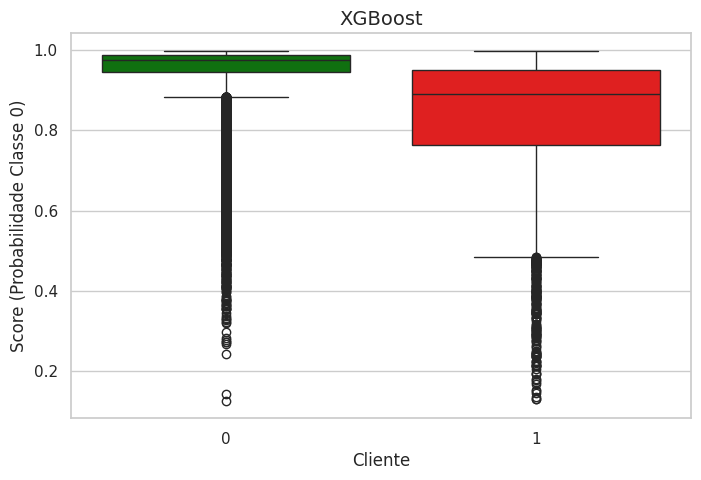

In [138]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=teste_com_predicoes, x='var_resposta', y='Prob_Classe_0', palette=["green", "red"])

plt.title('XGBoost', fontsize=14)
plt.xlabel('Cliente', fontsize=12)
plt.ylabel('Score (Probabilidade Classe 0)', fontsize=12)
plt.xticks([0, 1], labels=['0', '1'])  #
plt.show()


## Densidade

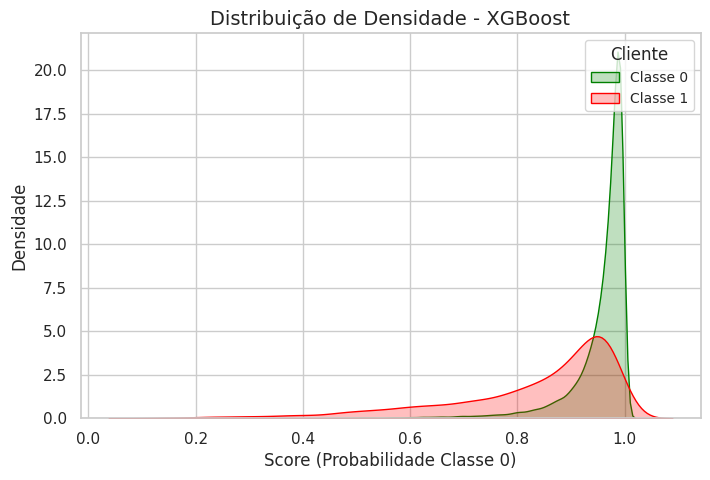

In [139]:
plt.figure(figsize=(8, 5))

sns.kdeplot(data=teste_com_predicoes[teste_com_predicoes['var_resposta'] == 0],
            x='Prob_Classe_0',
            fill=True,
            color="green",
            label="Classe 0")
sns.kdeplot(data=teste_com_predicoes[teste_com_predicoes['var_resposta'] == 1],
            x='Prob_Classe_0',
            fill=True,
            color="red",
            label="Classe 1")


plt.title('Distribuição de Densidade - XGBoost', fontsize=14)
plt.xlabel('Score (Probabilidade Classe 0)', fontsize=12)
plt.ylabel('Densidade', fontsize=12)
plt.legend(title='Cliente', fontsize=10, title_fontsize=12)
plt.show()


## Gráfico frequência versus taxa de inadimplência

In [140]:
bins = np.arange(0, 1100, 100)  # Intervalos de 0-100, 101-200, ..., 901-1000
teste_com_predicoes['Score_bin'] = pd.cut(teste_com_predicoes['Prob_Classe_0']*1000, bins=bins, right=False)

In [141]:
# Calcular frequência e taxa de inadimplência
freq = teste_com_predicoes.groupby('Score_bin').size()  # Contagem de observações
teste_com_predicoes['var_resposta'] = pd.to_numeric(teste_com_predicoes['var_resposta'], errors='coerce')
inadimplencia = teste_com_predicoes.groupby('Score_bin')['var_resposta'].mean()
inadimplencia

<ipython-input-141-69e15729090a>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq = teste_com_predicoes.groupby('Score_bin').size()  # Contagem de observações
<ipython-input-141-69e15729090a>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  inadimplencia = teste_com_predicoes.groupby('Score_bin')['var_resposta'].mean()


,var_resposta
Score_bin,
"[0, 100)",NaN
"[100, 200)",0.866667
"[200, 300)",0.862745
"[300, 400)",0.714286
"[400, 500)",0.526316
"[500, 600)",0.455796
"[600, 700)",0.324587
"[700, 800)",0.253128
"[800, 900)",0.143123


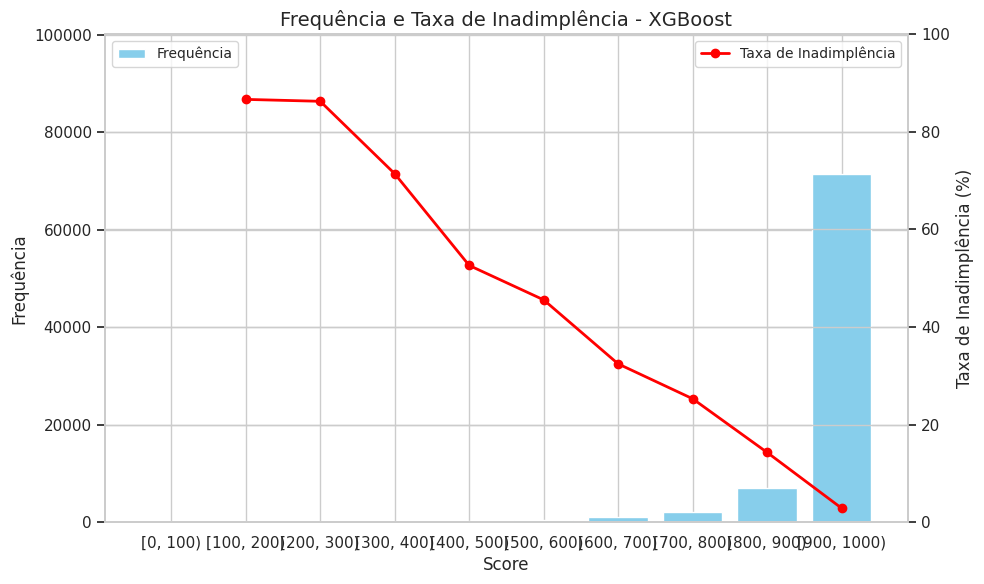

In [144]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(freq.index.astype(str), freq, color='skyblue', label='Frequência', width=0.8)
ax1.set_xlabel('Score', fontsize=12)
ax1.set_ylabel('Frequência', fontsize=12)
ax1.tick_params(axis='y')
ax1.set_ylim(0, freq.max() * 1.4)  # Ajustar limite do eixo Y

# Gráfico de linha para taxa de inadimplência
ax2 = ax1.twinx()
ax2.plot(freq.index.astype(str), inadimplencia * 100, color='red', marker='o', label='Taxa de Inadimplência', linewidth=2)
ax2.set_ylabel('Taxa de Inadimplência (%)', fontsize=12)
ax2.tick_params(axis='y')
ax2.set_ylim(0, 100)

# Títulos e legenda
plt.title('Frequência e Taxa de Inadimplência - XGBoost', fontsize=14)
fig.tight_layout()
ax1.legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)
plt.xticks(rotation=45)
plt.show()
